In this class you will learn basic knowledge of applied time series with Python.

# Smoothing time series 

Smoothing is a filtering technique to remove variation between time steps of a series. This is useful to reduce the noise in the series, identifying visually a trend component. Smoothing is useful as a preliminary inspection of the data. 

One of the most famous (and often criticized) smoothing technique in economics is the Hodrick-Prescott (HP) filter.
Given the following DGP:

\begin{equation}
y_{t} = g_{t}+c_{t}+\epsilon_{t}
\end{equation}

Where $g_{t}$ is the trend component, $c_{t}$ is the cyclical component and $\epsilon_{t}$ is a random component.
The HP filter models the trend component by the following minimization problem:


\begin{equation}
\min _{\left\{g_{t}\right\}_{t=-1}^{T}}\left\{\sum_{t=1}^{T}\left(y_{t}-g_{t}\right)^{2}+\lambda \sum_{t=1}^{T}\left[\left(g_{t}-g_{t-1}\right)-\left(g_{t-1}-g_{t-2}\right)\right]^{2}\right\}
\end{equation}

By solving this we obtain a closed-form solution for $g_t$, that should represent the trend of the series.

In [ ]:
!pip install fredapi #you need to install packages everytime you start a new runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
import seaborn as sns
import statsmodels.api as sm
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize
import scipy.stats as stats
from statsmodels.tsa.arima_model import ARIMA
from numpy.linalg import inv
from datetime import datetime
from pytz import timezone

We now upload GDP data from the FRED database:

In [ ]:
fred = Fred(api_key='a16aee5eab877dbcb71307417323bc99')
os='1996-01-01' 
oe = '2019-12-15' 

df = {}
df['GDP'] = fred.get_series('GDPC1', observation_start=os, observation_end=oe) #Real Gross Domestic Product 
df['GDP_pot'] = fred.get_series('GDPPOT', observation_start=os, observation_end=oe) # Real Potential Gross Domestic Product 
df = pd.DataFrame(df)

In [ ]:
df['output_gap'] = 100*(np.log(df.GDP) - np.log(df.GDP_pot))

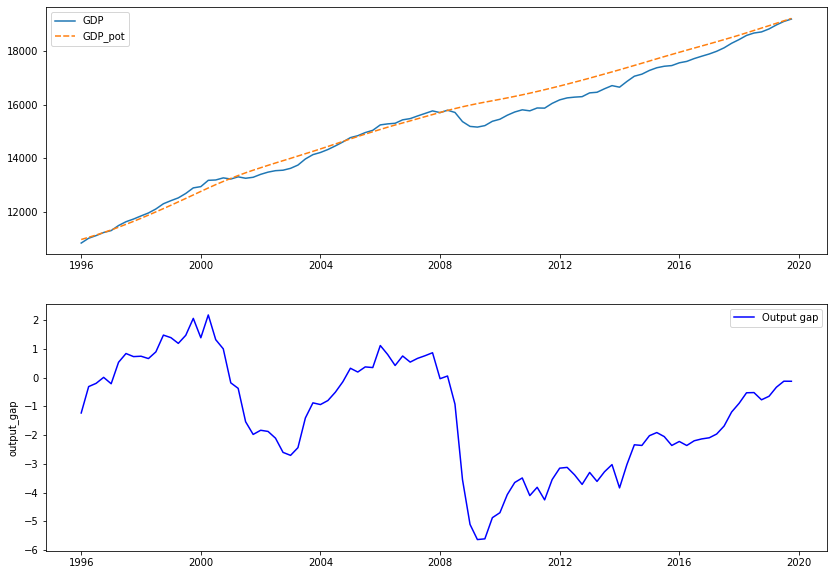

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

#fig.suptitle('Quarterly (official) shock '+str(shock), fontsize=20)
sns.lineplot(ax = axes[0], data = df.iloc[:,:2], legend = 'full', label='')
sns.lineplot(ax = axes[1], data = df.output_gap, legend = 'full', label='Output gap', color = 'b', estimator = 'mean')

In [ ]:
df['cycle'], df['trend'] = sm.tsa.filters.hpfilter(df.output_gap, 1600)

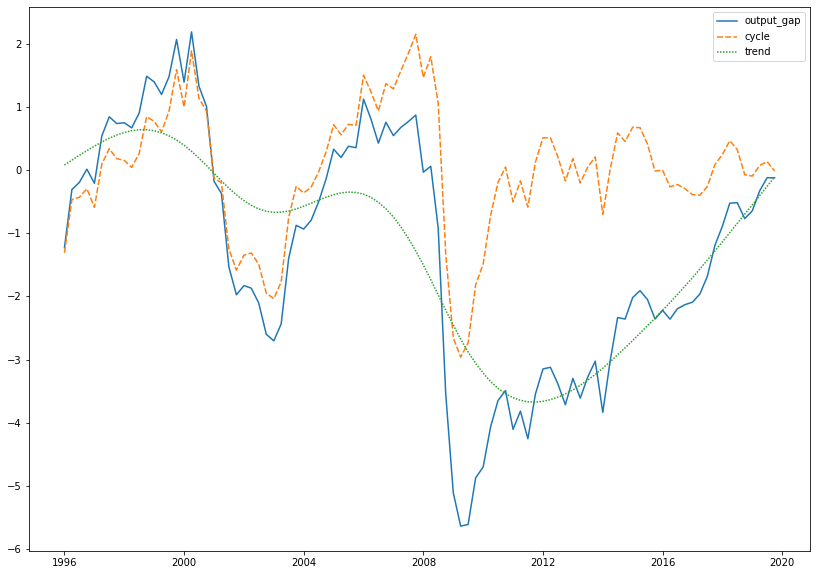

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
#fig.suptitle('Quarterly (official) shock '+str(shock), fontsize=20)
sns.lineplot(data = df.iloc[:,2:], legend = 'full', label='')
plt.show()

#plt.plot(df['cycle'])

The HP filter has many drawbacks and some of thm are well summarized by [Hamilton 2017](https://www.nber.org/papers/w23429). The main problem of this filter is that it cannot be used for forecast (you can understand why by looking at the formula).

# ARMA models

The ARMA models stands for autoregressive moving average models. These represent the basic for time series analysis because they provide an accurate and parsimonious description of a weakly stationary process. The ARMA$(p,q)$ model is be defined as:

\begin{equation}
y_{t}=c+\varepsilon_{t}+\sum_{i=1}^{p} \varphi_{i} y_{t-i}+\sum_{i=1}^{q} \psi_{i} \varepsilon_{t-i}
\end{equation}

where $\varepsilon_t$'s are white noise processes (i.i.d. random variables). 

We will start with a very simple process with no MA component $(q=0)$ and 1 auto regressive lag $(p=1)$.

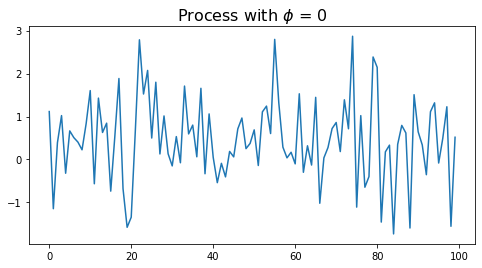

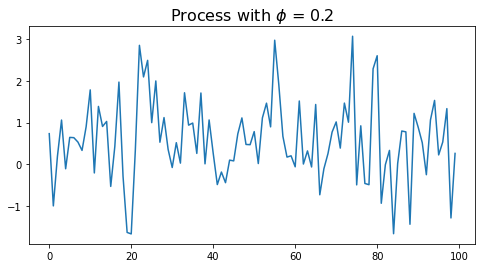

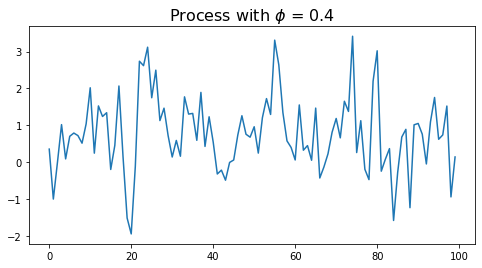

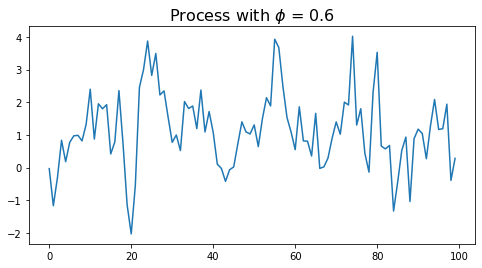

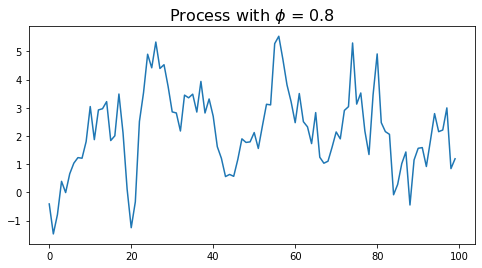

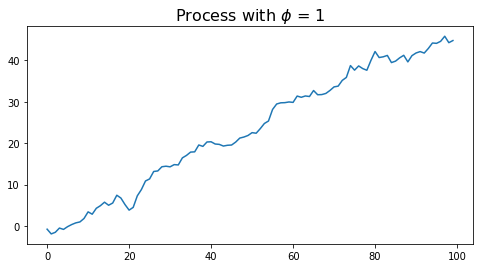

In [ ]:
#random.seed(10) #seed when you generate randomness by using random 
np.random.seed(10) #seed when you generate randomness by using numpy 
T = 101
eps = np.random.normal(0,1,T)
y = np.zeros(T)
y[0] = np.random.normal(0,1)
phis = [0, 0.2, 0.4, 0.6, 0.8, 1]
c = 0.4

for phi in phis:
    for t in range(1,T):
        y[t] = c + phi*y[t-1] + eps[t]
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(y[1:])
    ax.set_title('Process with ' + '$\phi$ = ' + str(phi), fontsize = 16)
    plt.show()


The differences by changing $\phi$ are quite evident. When $|\phi| < 1$ the AR(1) process is weakly stationary. This means that its mean and variance **are constant over time** (and the process do not present significant autocorrelation). When $|\phi| \geq 1$ there is a stochastic trend in the series, i.e. variance increase with time. You can eliminate the stochastic trend by differencing the series (in that case we say that the series is integrated of order 1 $I(1)$):

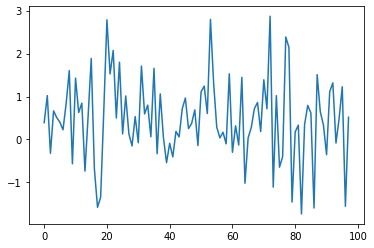

In [ ]:
def diff(x):
    return x[1:] - x[:-1]
y = y[1:]
y_diff = diff(y[1:])
plt.plot(y_diff)

Important instruments to understand the series dynamics are the autocorrelation function (ACF) and partial autocorrelation function (PACF)

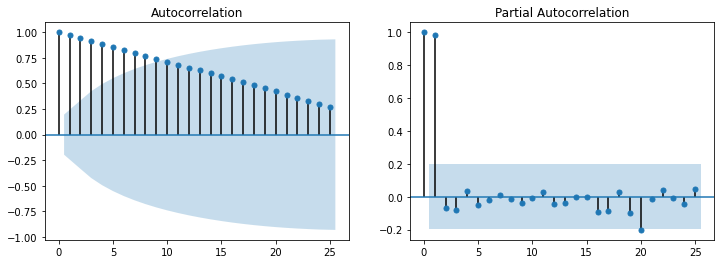

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
plot_acf(y,lags = 25,ax = ax)
ax = fig.add_subplot(1,2,2)
plot_pacf(y,lags = 25,ax = ax)
plt.show()

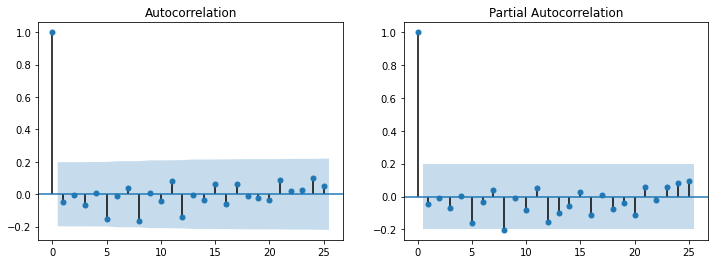

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
plot_acf(y_diff,lags = 25,ax = ax)
ax = fig.add_subplot(1,2,2)
plot_pacf(y_diff,lags = 25,ax = ax)
plt.show()

The Augmented Dickey-Fuller test is used to understand whether a series in integrated. The process is defined as:

\begin{equation}
\Delta y_{t}=\alpha+\beta t+\gamma y_{t-1}+\delta_{1} \Delta y_{t-1}+\cdots+\delta_{p-1} \Delta y_{t-p+1}+\varepsilon_{t}
\end{equation}

The test statistic is:

\begin{equation}
\mathrm{DF}_{\tau}=\frac{\hat{\gamma}}{\operatorname{SE}(\hat{\gamma})}
\end{equation}

and it is compared with the left DF critical values (asymmetric distribution). If $\mathrm{DF}_{\tau}$ is less (more negative) than the critical value we reject the null hypothesis of unit root presence.


In [ ]:
result = adfuller(y,regression = 'c') # ct - constant and trend; nc - no constant no trend
print('y:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(y_diff,regression = 'c') # ct - constant and trend; nc - no constant no trend
print('y_diff:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

y:
ADF Statistic: -0.721431
p-value: 0.841120
y_diff:
ADF Statistic: -10.213837
p-value: 0.000000


## Estimation

ARMA models are estimated via maximum likelihood estimation (MLE). This process has the aim of maximizing the likelihood function (conditional on $y_t$) with respect to the parameters of interest. For a Gaussian AR(1) the conditional likelihood function is:

\begin{equation}
\mathcal{L}(\theta \mid y)=\left(2 \pi \sigma^{2}\right)^{-N / 2} \prod_{i=1}^{N} \exp \left(-\frac{\left(y_{i}-\mu\right)^{2}}{2 \sigma^{2}}\right)
\end{equation}

Maximizing the likelihood function is the same as maximizing its log:

\begin{equation}
-\log \mathcal{L}(\theta \mid y)=\frac{1}{2} N \log\sigma^{2} + \frac{1}{2} N \log(2\pi) +\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(y_{i}-\mu\right)^{2}
\end{equation}

The AR(1) is a special and simple case where the first order condition gives you the same result as a least square problem. For more complicated process there are no close-form solution and coefficients are found via numerical optimization. We now program a MLE from scratch with Python:

In [ ]:
burn_in = 500
T = 1000 + burn_in
eps = np.random.normal(0,1,T)
y_raw = np.zeros(T)
phi = 0.5
for t in range(1,T):
    y_raw[t] = phi*y_raw[t-1] + eps[t]

y = y_raw[burn_in:]

T = y.shape[0]
def LL(params, y):
    # Resave the initial parameter guesses
    sigma = params[0]
    phi = params[1]

    

    # Calculate the negative log-likelihood as the negative sum of the log of a normal
    # PDF where the observed values are normally distributed around the mean (yPred)
    # with a standard deviation of sd
    logLik = (-T/2)*np.log(2*np.pi) - T/2*np.log(sigma)-1/(2*sigma)*np.sum((y[1:]-phi*y[:T-1])**2)

    # Tell the function to return the NLL (this is what will be minimized)
    return(-logLik)


x0=(1,0.2) #initial values

loglik = minimize(LL, x0, method='SLSQP',args = y, bounds = [(-1000.0,1000.0), (0.1,1000.0)],options={'disp': True})
estimates = loglik.x

print(estimates) #the value of the estimated phi should be very similar to phi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1393.418265180786
            Iterations: 7
            Function evaluations: 34
            Gradient evaluations: 7
[0.95023199 0.52544107]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


In [ ]:
model = ARIMA(y, order=(1,0,0))
model_fit = model.fit(disp=1)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1393.611
Method:                       css-mle   S.D. of innovations              0.975
Date:                Thu, 16 Jun 2022   AIC                           2793.223
Time:                        10:49:59   BIC                           2807.946
Sample:                             0   HQIC                          2798.819
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.065      0.025      0.980      -0.125       0.129
ar.L1.y        0.5249      0.027     19.522      0.000       0.472       0.578
                                    Roots           

# VAR models

The vector autoregressive models (VAR) consist in multivariate vectors of autoregressive processes, very important to model macroeconomic and financial relations. A very good manual for VAR anaysis is [Lütkepohl](https://link.springer.com/book/10.1007/978-3-540-27752-1).
A VAR process of order $p$ is defined as:

\begin{equation}
y_{t}=\nu+A_{1} y_{t-1}+\cdots+A_{p} y_{t-p}+u_{t}, \quad t=0, \pm 1, \pm 2, \ldots
\end{equation}

where $y_{t}=\left(y_{1 t}, \ldots, y_{K t}\right)^{\prime}$ is a $(K\times1)$ random vector, $A_i$ are matrix of coefficients and $u_t=\left(u_{1 t}, \ldots, u_{K t}\right)^{\prime}$ is a vector of random components where $E(u_t) = 0$, $E(u_t u_t^{\prime}) = \Sigma_u$ and $E(u_t u_s^{\prime}) = 0$ with $ s \neq t$.

In order to understand how to model these processes, we now consider a VAR of order 1:


\begin{equation}
y_{t}=v+A_{1} y_{t-1}+u_{t}
\end{equation}


\begin{equation}
\begin{aligned} y_{1} &=\nu+A_{1} y_{0}+u_{1} \\ y_{2} &=\nu+A_{1} y_{1}+u_{2}-\nu+A_{1}\left(\nu+A_{1} y_{0}+u_{1}\right)+u_{2} \\ &=\left(I_{K}+A_{1}\right) \nu+A_{1}^{2} y_{0}+A_{1} u_{1}+u_{2} \\ & \vdots \\ y_{t} &=\left(I_{K}+A_{1}+\cdots+A_{1}^{t-1}\right) \nu+A_{1}^{t} y_{0}+\sum_{i=0}^{t} A_{1}^{i} u_{t-i} \end{aligned}
\end{equation}

If all eigenvalues of $A_1$ have modulus less than 1 we will say that the VAR(1) is **stable** and can be writen as:

\begin{equation}
y_{t}=\mu+\sum_{i=0}^{\infty} A_{1}^{i} u_{t-i}, \quad t=0,+1,+2, \ldots
\end{equation}

with $\mu:=\left(\begin{array}{ll}I_{K} - A_{1}\end{array}\right)^{-1} \nu$. A stable VAR process recalls the same concept of stationarity for a univariate time series. Hence, it is a process with constant mean and variance. We can re-write a kp-dimensional VAR in the compact VAR(1) form:

\begin{equation}
Y_{t}=\nu+\mathbf{A} Y_{t-1} +U_{t}
\end{equation}

where:

\begin{equation}
Y_{t}:=\left[\begin{array}{c}y_{t} \\ y_{t-1} \\ \vdots \\ y_{t-p+1} \\ (K p \times 1)\end{array}\right], \quad \boldsymbol{\nu}:=\left[\begin{array}{c}\nu \\ 0 \\ \vdots \\ 0\end{array}\right]
\end{equation}



\begin{equation}
\mathbf{A}:=\left[\begin{array}{ccccc}A_{1} & A_{2} & \ldots & A_{p-1} & A_{p} \\ I_{K} & 0 & \ldots & 0 & 0 \\ 0 & I_{K} & & 0 & 0 \\ \vdots & & \ddots & \vdots & \vdots \\ 0 & 0 & \ldots & I_{K} & 0\end{array}\right], \quad U_{t}:=\underset{(K p \times K p)}{\left[\begin{array}{c}u_{t} \\ 0 \\ \vdots \\ 0\end{array}\right]}
\end{equation}

The process is stable if its reverse characteristic polynomial has no roots in and on the complex unit circle. Formally the VAR(p) is stable if:

\begin{equation}
\operatorname{det}\left(I_{K}-A_{1} z-\cdots-A_{p} z^{p}\right) \neq 0 \quad \text { for }|z| \leq 1
\end{equation}



## Estimation

The estimation of stable VAR models is called multivariate least squares and corresponds to an OLS estimation row-by-row of the VAR equations. By re-writing the VAR process, we can find a compact form to estimate the parameters (without going trough each row to perform the OLS). Let's consider the following notation:

\begin{equation}
\begin{array}{ll}Y:=\left(y_{1}, \ldots, y_{T}\right) & (K \times T) \\ B:=\left(\nu, A_{1}, \ldots, A_{p}\right) & (K \times(K p+1))\end{array}
\end{equation}

\begin{equation}
Z_{t}:=\left[\begin{array}{c}1 \\ y_{t} \\ \vdots \\ y_{t-p+1}\end{array}\right] \quad((K p+1) \times 1)
\end{equation}

\begin{equation}
\begin{aligned} Z:=\left(Z_{0}, \ldots, Z_{T-1}\right) &((K p+1) \times T) \\ U:=\left(u_{1}, \ldots, u_{T}\right) &(K \times T) \\ \mathbf{y}:=\operatorname{vec}(Y) &(K T \times 1) \\ \boldsymbol{\beta}:=\operatorname{vec}(B) &\left(\left(K^{2} p+K\right) \times 1\right) \\ \mathbf{b}:=\operatorname{vec}\left(B^{\prime}\right) &\left(\left(K^{2} p+K\right) \times 1\right) \\ \mathbf{u}:=\operatorname{vec}(U) &((K T \times 1)\end{aligned}
\end{equation}

We can re-write a VAR(p) in compact form:

\begin{equation}
Y=B Z+U
\end{equation}

We can estimate (you might want to take a look at the book to get insights on the proof) the matrix of coefficients $A_j$ stacked in $B$ with LS formula:


\begin{equation}
\widehat{B}=Y Z^{\prime}\left(Z Z^{\prime}\right)^{-1}
\end{equation}

and also the variance-covariance matrix of the residuals:

\begin{equation}
\hat{\Sigma}_{u}=\frac{1}{T} \sum_{t=1}^{T} \widehat{u}_{t} \widehat{u}_{t}^{\prime}=\frac{1}{T} \widehat{U} \widehat{U}^{\prime}=\frac{1}{T}(Y-\widehat{B} Z)(Y-\widehat{B} Z)^{\prime}
\end{equation}

Notice that Dividing the elements of $B$ by the square roots of the corresponding diagonal of $\left(Z Z^{\prime}\right)^{-1} \otimes \widehat{\Sigma}_{u}$ we get the matrix of t-ratios for inference.


I provide below a function that estimates a stable VAR, given the multivariate process $y$, its order $p$ and a dummy that controls for intercept:

In [ ]:
def VARls(y,p,inc):
    Traw=np.size(y,axis=0)
    K=np.size(y,axis=1)
    T=Traw-p
    Y=y[p:,:].T
    a=np.empty((1,K,))
    a[:]=np.NaN
    rhs=[]
    r=y
    for i in range(p):
        r=np.vstack((a,r))
        h=np.delete(r,np.s_[Traw:],0)
        if i>0:
            rhs=np.hstack((rhs,h))
        else:
            rhs=h
    Z=rhs[p:,:].T
    if inc==1:
        Z=np.vstack((np.ones(T),Z))
    Bhat = np.dot(np.dot(Y,Z.T),inv(np.dot(Z,Z.T)))
    Uhat = (Y-np.dot(Bhat,Z))
    Sigmahat = np.dot(Uhat,Uhat.T)/(T-K*p)
    corr = (np.array([Sigmahat[np.triu_indices(K, 1)[::-1]]] ).T)
    corr_mean = np.mean(np.abs(corr))
    return Bhat,Sigmahat,Uhat,Traw,K,Z,corr,corr_mean

In [ ]:
os='1996-01-01' 
oe = '2019-12-15' #'2019-12-15'

df = {}
df['oil'] = fred.get_series('MCOILWTICO', observation_start=os, observation_end=oe) #PRS30006163
df['GDP'] = fred.get_series('GDPC1', observation_start=os, observation_end=oe) 
df['GDP_pot'] = fred.get_series('GDPPOT', observation_start=os, observation_end=oe) 
df['Unemp'] = fred.get_series('UNRATE', observation_start=os, observation_end=oe) 
df['n_rate'] = fred.get_series('NROU', observation_start=os, observation_end=oe) 
df['infl'] = fred.get_series('GDPDEF', observation_start=os, observation_end=oe) 
df['ir'] = fred.get_series('DFF', observation_start=os, observation_end=oe) 
df['loan'] = fred.get_series('NASDAQCOM', observation_start=os, observation_end=oe) 
df = pd.DataFrame(df)

df_original = df.resample('Q').mean()



df_original['gdp_diff'] = np.log(df_original.GDP) #- np.log(df_original.GDP.shift(1)) 
df_original['gdp_pot_diff'] = np.log(df_original.GDP_pot) #- np.log(df_original.GDP_pot.shift(1)) 
df_original['un_diff'] = np.log(df_original.Unemp) - np.log(df_original.Unemp.shift(1)) 
df_original['n_rate_diff'] = np.log(df_original.n_rate) - np.log(df_original.n_rate.shift(1)) 
df_original['oil_diff'] = np.log(df_original.oil) - np.log(df_original.oil.shift(1)) 


df_original['output'] =  (100*(df_original['gdp_diff'] - df_original.gdp_pot_diff))
df_original['unemployment'] = (df_original.Unemp - df_original.n_rate)
df_original['inflation'] = 400 * (np.log(df_original.infl)).diff()
df_original['fed_rate'] =  df_original.ir  #np.log(df_original.ir) - np.log(df_original.ir.shift(1))

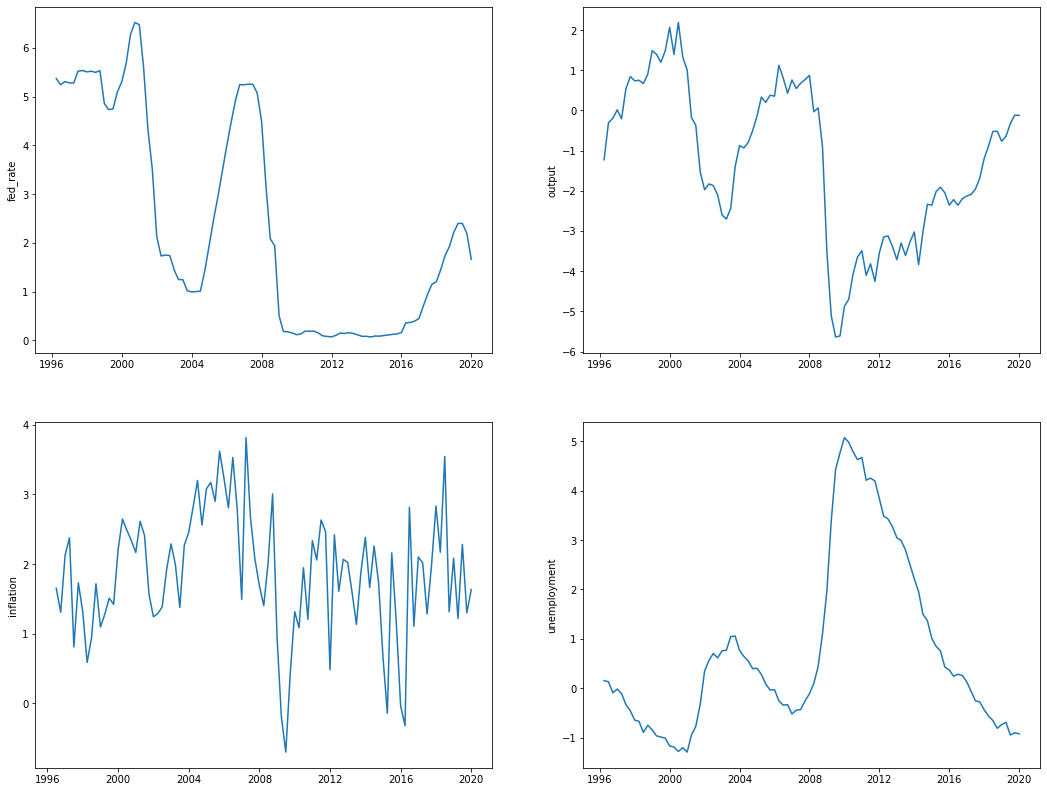

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
sns.lineplot(ax = axes[0,0], data = df_original['fed_rate'], legend = 'full', label='')
sns.lineplot(ax = axes[0,1], data = df_original['output'], legend = 'full', label='')
sns.lineplot(ax = axes[1,1], data = df_original['unemployment'], legend = 'full', label='')
sns.lineplot(ax = axes[1,0], data = df_original['inflation'], legend = 'full', label='')


## Information criteria

Information criteria are needed to select the order of the model. The forecast error of a model is defined as:

\begin{equation}
\Sigma_{\widehat{y}}(1)=\frac{T+K m+1}{T} \Sigma_{u}
\end{equation}

The information criteria select the order that minimizes the forecast error (some information criteria include penalizations for higher order).

In [ ]:
def inf_criteria(Yraw, pmax, inc): #function for information criteria
    FPEraw=np.zeros(pmax+1)
    AICraw=np.zeros(pmax+1)
    HQraw=np.zeros(pmax+1)
    BICraw=np.zeros(pmax+1)
    [TpPmax , K]=np.size(Yraw,axis=0), np.size(Yraw,axis=1)
    T = TpPmax - pmax
    for m in range(1,pmax+1):
        Y=Yraw[(1+(pmax-m)):,:] # same estimation length for all 
        [_,_,Uhat,_,_,_,_,_]=VARls(Y,m,inc) #function does not adjust for degrees of freedom in the VAR estimators
        Sigmahat = np.dot(Uhat,Uhat.T)/T
        FPEraw[m]=np.power(((T+K*m+1)/(T-K*m-1)),K) * np.linalg.det(Sigmahat) #Criteria Values
        AICraw[m]=np.log(np.linalg.det(Sigmahat))+(2*m*K**2)/T
        HQraw[m]=np.log(np.linalg.det(Sigmahat)) + (2 * np.log(np.log(T)))/T * m * K**2
        BICraw[m]=np.log(np.linalg.det(Sigmahat))+ (np.log(T))/T * m* K**2

    FPE=np.argmin(FPEraw[1:]) #Index of the Minimum 
    FPE=FPE+1
    AIC=np.argmin(AICraw[1:])
    AIC=AIC+1
    HQ=np.argmin(HQraw[1:])
    HQ=HQ+1
    BIC=np.argmin(BICraw[1:])
    BIC=BIC+1
    return FPE, AIC, HQ, BIC

In [ ]:
y_q_l = df_original.iloc[1:,-4:].to_numpy()
Q = y_q_l.shape[0]    
    
print(inf_criteria(y_q_l,10,0))

(2, 2, 2, 2)


In [ ]:
y_q_l1 = y_q_l.copy()
K = y_q_l1.shape[1]
p=2

Bq,sigma1,Uhat_q,_,_,Zq,_,_ = VARls(y_q_l1,p,0)
print(Bq.shape)

(4, 8)


In [ ]:
Bq

array([[ 0.9727043 , -0.5640469 , -0.08725774,  0.40669012, -0.13860894,
         0.46959151, -0.03522453, -0.35971852],
       [-0.1086448 ,  1.48376001, -0.01391197, -0.18228796,  0.13163947,
        -0.48343873,  0.02883336,  0.17828296],
       [ 0.36883124, -0.31370449,  0.38382985,  0.20914719, -0.55353003,
         0.27692608,  0.28761874, -0.05126123],
       [ 0.0566415 , -0.04615291, -0.00200966,  1.59233188, -0.05637597,
         0.03919023,  0.03478945, -0.62734704]])

## Impulse response functions

The impulse response functions consist in shocking the variable (the residual of the variable of interest, to be precise) of the VAR system and see how this propagates over time. Let's consider a VAR(1) for simplicity:

\begin{equation}
y_t = A_1 y_{t-1} + u_t
\end{equation}

At time 0 we give a shock to the k-th variable in the vector of noise:

\begin{equation}
y_0 = u_0.
\end{equation}

\begin{equation}
y_j = A^ju_0
\end{equation}

We can see how the shock propagates on K variables of the VAR over time. You can see that all depends on the matrix of coefficients. 

With VAR models we can use the impulse response functions to understand the underlying causal mechanism between the variables. If we are able to say that the shock on $u_t$ is an exogenous shock on an economic variable, then we can use IRFs to understand the causal effect of such shock on the economy. Unfortunately, we can estimate the error components but we cannot relate them to economic shocks. In order to learn about causality we have to write the VAR in its structural form (structural VAR):

\begin{equation}
B_0y_t = B_1 y_{t-1} + e_t
\end{equation}

From the strucutral form you can go to the standard VAR form by multiplying for $B_0^{-1}$. In this case we have that $A_1 = B_0^{-1}B_1$ and $u_t = B_0^{-1}e_t$. Indeed, what we can observe after estimation ($u_t$) is a linear combination between the matrix of contemporaneous relation ($B_0$) and the structural shocks ($e_t$).

We can compute the variance-covariance matrix of the residuals. This will be equal to:

\begin{equation}
\Sigma_u = E[B_0^{-1}e_te_t^{\prime}B_0^{-1\prime}] = B_0^{-1} B_0^{-1\prime}
\end{equation}

We cannot identify $B_0$. Why?

On the non-diagonal elements of $B_0$ there are the contemporaneous correlation that does not allow to directly identify the economic shocks. The easiest way to overcome the problem is to impose restrictions on $B_0$, for example Cholesky decomposition.

Let's now see how we can make structural analysis on Python:

In [ ]:
y_q_l = np.zeros((Q,K))

Traw = Q


Y=y_q_l[p:,:].T
a=np.empty((1,K,))
a[:]=np.NaN
rhs=[]
r=y_q_l
for i in range(p):
    r=np.vstack((a,r))
    h=np.delete(r,np.s_[Traw:],0)
    if i>0:
        rhs=np.hstack((rhs,h))
    else:
        rhs=h
Z=rhs[p:,:].T

In [ ]:
shock = 3 #monetary policy shock
U = np.zeros(K*p)
chol2 = np.linalg.cholesky(sigma1)
U[shock] = 1/chol2[shock,shock]
print(np.dot(chol2, U[:K]))

[0. 0. 0. 1.]


In [ ]:
period_display = 40

In [ ]:
U[:K] = np.dot(chol2, U[:K])
Z[:,0] = U
y_q_l[p-1,:] = U[:K]
for t in range(p,y_q_l.shape[0]-1):
    y_q_l[t,:] = np.dot(Bq,Z[:,t-p])
    Z[:,t-p+1] = np.reshape(np.vstack((y_q_l[t,:], y_q_l[t-p+1:t,:][::-1] )), (K*p))

y_q_l = y_q_l.T
y_q_l = y_q_l[:,p-1:]


irf = y_q_l[:,:(period_display)]
irf.shape

(4, 40)

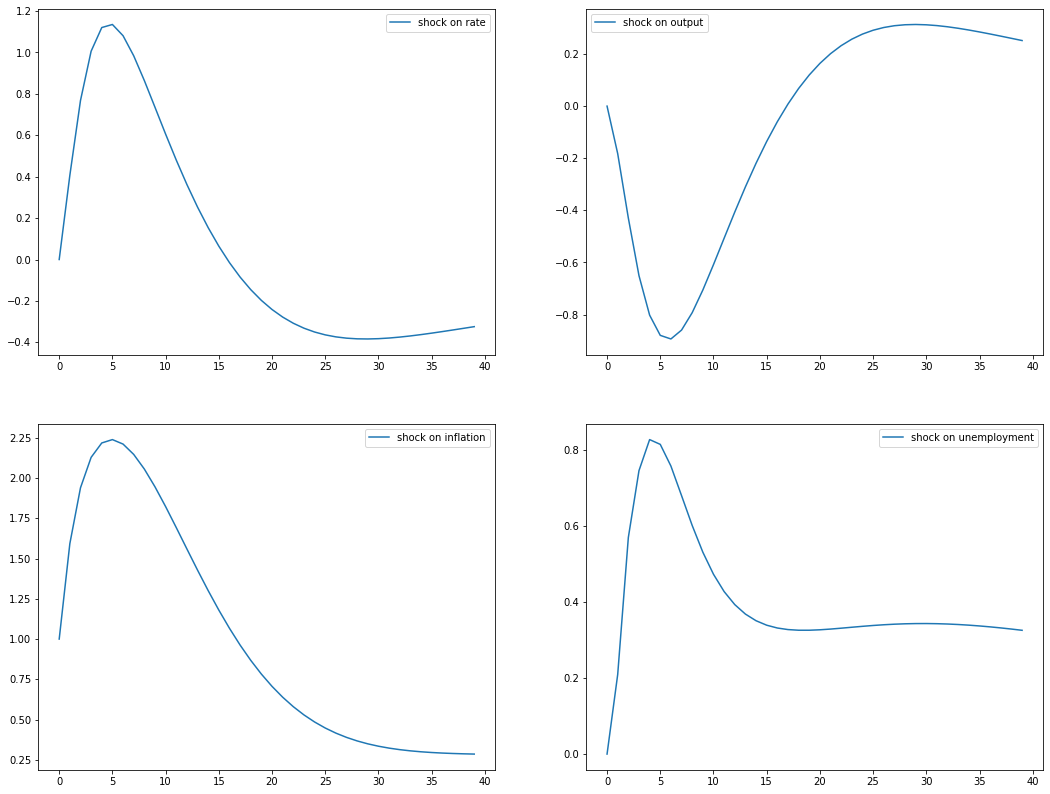

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
sns.lineplot(ax = axes[0,0], data = irf[0,:], legend = 'full', label='shock on rate')
sns.lineplot(ax = axes[0,1], data = irf[1,:], legend = 'full', label='shock on output')
sns.lineplot(ax = axes[1,1], data = irf[2,:], legend = 'full', label='shock on unemployment')
sns.lineplot(ax = axes[1,0], data = irf[3,:], legend = 'full', label='shock on inflation')

Did we really identify a monetary policy shock? And why we did not?

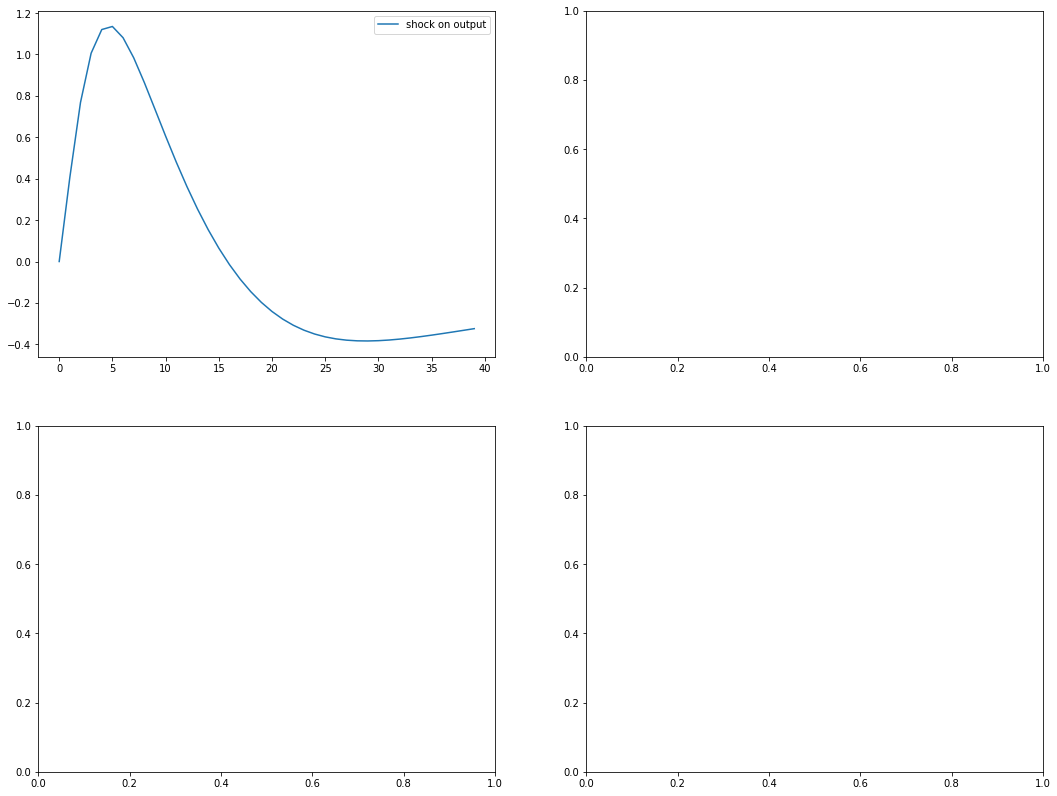

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
sns.lineplot(ax = axes[0,0], data = irf[0,:], legend = 'full', label='shock on output')
